In [8]:
"""
Ce script permet de visualiser l'évolution de la hauteur de l'eau en 2D en fonction du temps.
Il faut spécifier le numéro de l'expérience, le paramètre à visualiser (hauteur de l'eau ou norme du débit)
et la résolution (HR ou LR).
"""

import os
import numpy as np
import matplotlib
from numpy import ndarray

matplotlib.use("TkAgg") # to show animation in PyCharm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [9]:
# Paramètres de l'animation
num_seconds = 600
num_experiments = 1
parameter = "q_norm_evol" # h_evol ou q_norm_evol
resolution = "HR" # HR ou LR

folder_path = f"../donnees/experiences/{num_experiments}/{parameter+'_'+resolution}" # Dossier contenant les fichiers

In [3]:
"""
Function to load the data for a given frame
Load the data from the file h_evol_{frame}.txt in the folder_path
Parameters: frame - the time to load the data for
Return the data as a 2D numpy array
"""
def load_data_for_time(frame) -> ndarray|None:
    file_name = f"{parameter}_{frame + (((num_experiments-1) * 600) + (num_experiments-1))}.txt"
    file_path = os.path.join(folder_path, file_name)

    if os.path.exists(file_path):
        data = np.loadtxt(file_path, delimiter=";")
        if resolution == "LR" and data.ndim == 1:
            data = data.reshape(1, -1)  # Reshape to 2D if it's a single line
        if data.ndim == 2:
            return data
        else:
            print(f"Invalid data shape {data.shape} in file: {file_name}")
            return None
    else:
        print(f"Fichier manquant : {file_name}")
        return None

In [4]:
"""
Function to search the maximum value in the data (all files)
Search the maximum value in the data from the files in the folder_path
Return the maximum value and the minimum value
"""
def search_extremum_values() -> tuple:
    max_value = 0
    min_value = 0

    for time in range(0, num_seconds + 1):
        data_2d = load_data_for_time(time)

        if data_2d is not None:
            max_value = max(max_value, np.max(data_2d))
            min_value = min(min_value, np.min(data_2d))

    return min_value, max_value

In [5]:
"""
Function to initialize the plot
Create a figure with a 2D matrix of zeros and a colorbar
Return the figure, the axes, the image and the colorbar
"""
def init() -> list:
    minimum, maximum = search_extremum_values()

    fig, ax = plt.subplots()  # Create a figure and axes.
    im = ax.imshow(np.zeros((5, 250)) if resolution=="HR" else np.zeros((1,50)), cmap='plasma', interpolation='nearest', aspect=25, vmin=minimum, vmax=maximum)

    ax.set_title("Evolution des données 2D")
    ax.set_xlabel("Index X")
    ax.set_ylabel("Index Y")
    cbar = plt.colorbar(im, ax=ax, label=f'{"Valeurs de la hauteur eau" if parameter=="h_evol" else "Valeurs de la norme du débit"}')
    cbar.set_ticks(np.linspace(minimum, maximum, 15))

    return [fig, ax, im]

In [6]:
"""
Function to update the plot
Change the data of the image to the data for the current time
Parameters: frame - the current time, image - the image to update, axes - the axes of the plot
Return the updated image
"""
def update(frame, image, axes) -> list:
    data_2d = load_data_for_time(frame)

    if data_2d is not None:
        image.set_data(data_2d)

    axes.set_title(f"Evolution de {parameter} - Expérience {num_experiments} - Seconde {frame} - {resolution}")
    return image

In [10]:
def __main__() -> None:
    figure, axes, image = init()
    # Create a variable to not delete the animation before the end
    animation = FuncAnimation(figure, update, fargs=(image, axes), frames=range(0, num_seconds))
    plt.tight_layout() # To space the plot correctly
    plt.show()

__main__()

Partie réseau de neurone

Import des données

In [6]:
import torch
import numpy as np

def extract_experiment_data(experiment_number):
    input = []
    target = []
    for t in range(0, 601):
        data = np.loadtxt("../donnees/experiences/"+str(experiment_number)+"/h_evol_LR/h_evol_" +str(t + (experiment_number-1)*601) +".txt", delimiter=";")
        data2 = np.loadtxt("../donnees/experiences/"+str(experiment_number)+"/h_evol_HR/h_evol_" +str(t + 601*(experiment_number-1)) +".txt", delimiter=";")
        input.append(data)
        target.append(data2)
    return input, target
    

input , target = extract_experiment_data(1)

inputs_tensor = torch.tensor(np.array(input), dtype=torch.float32)
targets_tensor = torch.tensor(np.array(target), dtype=torch.float32)

print(inputs_tensor.shape)
# torch.Size([601, 50])
print(targets_tensor.shape)
#torch.Size([601, 5, 250])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(inputs_tensor[300].reshape(1, 50), cmap='plasma', interpolation='nearest', aspect=25)
plt.title('Input Tensor')

plt.subplot(1, 2, 2)
plt.imshow(targets_tensor[300], cmap='plasma', interpolation='nearest', aspect=25)
plt.title('Target Tensor')

plt.show()

torch.Size([601, 50])
torch.Size([601, 5, 250])


In [2]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(50, 100),       
            nn.ReLU(),
            nn.Linear(100, 500),     
            nn.ReLU(),
            nn.Linear(500, 1250), 
            nn.Sigmoid(),      
        )
    
    def forward(self, x):
        return self.model(x)

In [5]:
from torch.utils.data import DataLoader, TensorDataset

def set_input_tensor(input_tensor):
    tensor1_flattened = input_tensor.view(1, 50)
    return tensor1_flattened.unsqueeze(0)

def set_target_tensor(target_tensor):
    tensor_flattened = target_tensor.view(1, 5, 250)
    tensor_flattened = tensor_flattened.view(1, 5 * 250)
    return tensor_flattened.unsqueeze(0)


dataset = TensorDataset(set_input_tensor(inputs_tensor[400]), set_target_tensor(targets_tensor[400]))
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
model = SimpleNN()

loss_function = nn.MSELoss()  # Fonction de perte
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimiseur

predictions_store = []

# Boucle d'entraînement
epochs = 501 # Nombre d'époques
for epoch in range(epochs):
    predictions = model(set_input_tensor(inputs_tensor[400]))
    loss = loss_function(predictions, set_target_tensor(targets_tensor[400]))  
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #store every 100 prediction in a tensor
    if epoch % 100 == 0:
        predictions_store.append(predictions)
        print(f"Epoch {epoch + 1}, loss {loss.item()}")


#concatenate all the predictions in a single tensor
predictions = torch.cat(predictions_store, dim=0)
print(predictions[-1].shape)
sortie = predictions[-1].view(5, 250)
print("Prédiction : ")
print("min ", torch.min(sortie))
print("max ", torch.max(sortie))
print("Target : ")
print("min ", torch.min(targets_tensor[300]))
print("max ", torch.max(targets_tensor[300]))
print(sortie.min)
plt.imshow(sortie.detach().numpy(), cmap='plasma', interpolation='nearest', aspect=25)
plt.show()

Epoch 1, loss 0.07465565204620361
Epoch 101, loss 1.5701467646067613e-06
Epoch 201, loss 3.193166286941107e-10
Epoch 301, loss 2.3658353582949564e-14
Epoch 401, loss 1.1420864188673932e-16
Epoch 501, loss 8.08575401517689e-17
torch.Size([1, 1250])
Prédiction : 
min  tensor(0.0620, grad_fn=<MinBackward1>)
max  tensor(0.4076, grad_fn=<MaxBackward1>)
Target : 
min  tensor(0.0042)
max  tensor(0.4013)
<built-in method min of Tensor object at 0x7ae19f51ca40>


In [4]:
#Load model dict from .pt file
from NeuralNetworkTracéPerte import Simple1NN
import torch

model = Simple1NN()

model.load_state_dict(torch.load('/home/puyfages/Data/DataScienceProj/DataProject/script/simple_nn_h_model.pth20250113-125513')) 

/tmp/ipykernel_13528/2118972854.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/puyfages/Data/DataScienceProj/DataProject/script/

<All keys matched successfully>

In [6]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 2.5 MB/s eta 0:00:00a 0:00:01


In [9]:
model.model[0]

Linear(in_features=50, out_features=1250, bias=True)

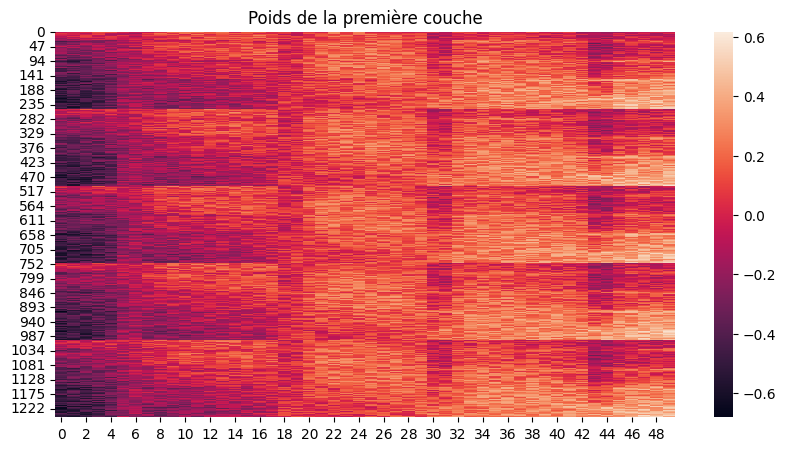

In [7]:
#plot the model parameters as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.heatmap(model.model[0].weight.detach().numpy(), ax=ax)
plt.title('Poids de la première couche')

plt.show()